In [ ]:
!git clone https://github.com/lehoangphuongnhi/Thesis.git

Cloning into 'Thesis'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 234 (delta 22), reused 18 (delta 7), pack-reused 181
Receiving objects: 100% (234/234), 11.15 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
cd Thesis

/content/Thesis


In [ ]:
!make start-gpu
!pip install wget

make: *** No rule to make target 'start-gpu'.  Stop.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=0b993bd2bd066354a917f951732878e48f954933d638cf741202f4fe94d634a5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from Code.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download Poker Hand dataset

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data"
dataset_name = 'poker-hand-train'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [ ]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

In [ ]:
url_1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data"
dataset_name_1 = 'poker-hand-test'
out_1 = Path(os.getcwd()+'/data/'+dataset_name_1+'.csv')

In [ ]:
out_1.parent.mkdir(parents=True, exist_ok=True)
if out_1.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url_1, out_1.as_posix())

# Load data and split

In [ ]:
feature_columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Poker Hand']

In [ ]:
train = pd.read_csv(out, header = None, names = feature_columns)

In [ ]:
test = pd.read_csv(out_1, header = None, names = feature_columns)

In [ ]:
n_total = len(train)

train_indices, valid_indices = train_test_split(
    range(n_total), test_size=0.1, random_state=0)

# Simple preprocessing

In [ ]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

S1 4
C1 13
S2 4
C2 13
S3 4
C3 13
S4 4
C4 13
S5 4
C5 13
Poker Hand 10


In [ ]:
for col in test.columns:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
        #categorical_columns.append(col)
        #categorical_dims[col] = len(l_enc.classes_)

S1 4
C1 13
S2 4
C2 13
S3 4
C3 13
S4 4
C4 13
S5 4
C5 13
Poker Hand 10


In [ ]:
target = 'Poker Hand'

In [ ]:
features = [ col for col in train.columns if col not in [target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
features

['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5']

In [ ]:
cat_idxs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
cat_dims

[4, 13, 4, 13, 4, 13, 4, 13, 4, 13]

In [ ]:
im = pd.DataFrame()

In [ ]:
im = train['Poker Hand'].value_counts()

In [ ]:
im

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: Poker Hand, dtype: int64

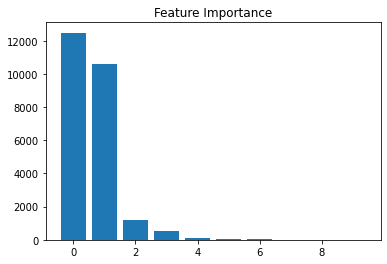

In [ ]:
plt.figure()
plt.bar(im.index, im.values)
plt.title("Feature Importance")
plt.show()

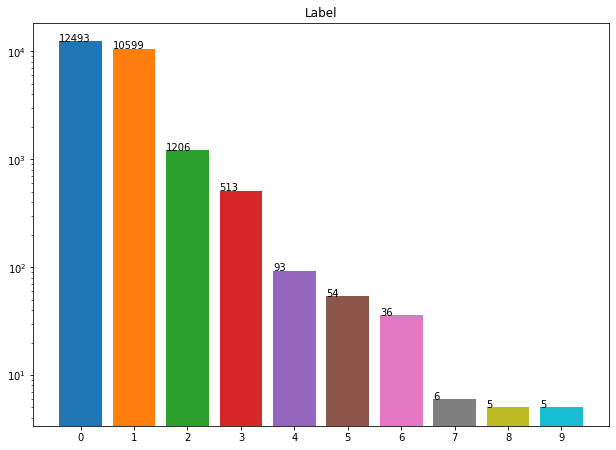

In [ ]:
y = train['Poker Hand'].groupby(train['Poker Hand']).size()
fig = plt.figure(figsize = (10, 7))
ax = fig.add_axes([0.5,0.5,.8,.8])
ax.set_title('Label')
ax.set_yscale('log')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
for val in range(len(y)):
    ax.annotate(str(y[val]), xy = (val, y[val]), xytext = (val-.4, y[val]))
    ax.bar(val,y[val])
plt.show()

# Training

In [ ]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = test[features].values
y_test = test[target].values

In [ ]:
clf = TabNetClassifier(
    n_d=128, n_a=128, n_steps=4,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=[3,12,3,12,3,12,3,12,3,12],
    gamma=1.5, n_ind=2, n_shared=2,
    lambda_sparse=1e-6, momentum=0.05, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 80},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'val'],
    max_epochs=800, patience=100,
    batch_size=4096, vbs=1024 #, augmentations=aug
) 

epoch 0  | loss: 2.26043 | train_accuracy: 0.43947 | val_accuracy: 0.42863 |  0:00:00s
epoch 1  | loss: 1.34992 | train_accuracy: 0.47403 | val_accuracy: 0.45822 |  0:00:01s
epoch 2  | loss: 1.18359 | train_accuracy: 0.48007 | val_accuracy: 0.46941 |  0:00:01s
epoch 3  | loss: 1.13228 | train_accuracy: 0.48127 | val_accuracy: 0.47341 |  0:00:02s
epoch 4  | loss: 1.09489 | train_accuracy: 0.48327 | val_accuracy: 0.47061 |  0:00:03s
epoch 5  | loss: 1.05795 | train_accuracy: 0.48105 | val_accuracy: 0.46821 |  0:00:03s
epoch 6  | loss: 1.02709 | train_accuracy: 0.48932 | val_accuracy: 0.47661 |  0:00:04s
epoch 7  | loss: 1.01778 | train_accuracy: 0.49798 | val_accuracy: 0.4918  |  0:00:04s
epoch 8  | loss: 1.0102  | train_accuracy: 0.49727 | val_accuracy: 0.47621 |  0:00:05s
epoch 9  | loss: 0.99654 | train_accuracy: 0.49762 | val_accuracy: 0.46661 |  0:00:05s
epoch 10 | loss: 0.99403 | train_accuracy: 0.50144 | val_accuracy: 0.47221 |  0:00:06s
epoch 11 | loss: 0.99362 | train_accuracy: 

/content/Thesis/Code/callbacks.py:155: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Predictions

In [ ]:
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR poker-hand-train : 0.966511


# Save and load model

In [ ]:
saved_filename = clf.save_model('poker-hand')

Successfully saved model at poker-hand.zip


In [ ]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model('poker-hand.zip')

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict(X_test)
#loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_preds, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

# Global explainability: feat importance summing to 1

In [ ]:
loaded_clf._compute_feature_importances(X_test)

array([0.02054544, 0.22912998, 0.00661577, 0.23512226, 0.00986172,
       0.06326218, 0.0049203 , 0.16504643, 0.0719154 , 0.19358052])

In [ ]:
loaded_clf._compute_feature_importances(X_train)

array([0.02105085, 0.22631548, 0.0066539 , 0.2353577 , 0.00994821,
       0.06405305, 0.00482431, 0.1665125 , 0.07141772, 0.19386628])

In [ ]:
loaded_clf._compute_feature_importances(X_valid)

array([0.02026774, 0.22975839, 0.00675487, 0.23404117, 0.00958988,
       0.06038228, 0.00536242, 0.16497866, 0.07522375, 0.19364085])

In [ ]:
clf.feature_importances_

array([0.02105085, 0.22631548, 0.0066539 , 0.2353577 , 0.0099482 ,
       0.06405305, 0.00482431, 0.16651251, 0.07141772, 0.19386628])

In [ ]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = features
feature_importances["importance"] = clf.feature_importances_

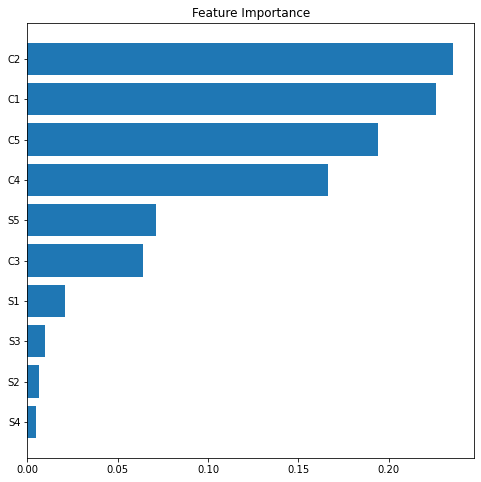

In [ ]:
feature_importances.sort_values(
    by = "importance", 
    ascending = True, 
    inplace = True
)
plt.figure(figsize = (8, 8))
plt.barh(feature_importances["feature"], feature_importances["importance"])
plt.title("Feature Importance")
plt.show()

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
explain_matrix.sum(axis = 0)/np.sum(explain_matrix.sum(axis = 0))

array([0.02054544, 0.22912998, 0.00661577, 0.23512227, 0.00986172,
       0.06326218, 0.0049203 , 0.16504643, 0.07191539, 0.19358052])

Text(0.5, 1.0, 'mask agg')

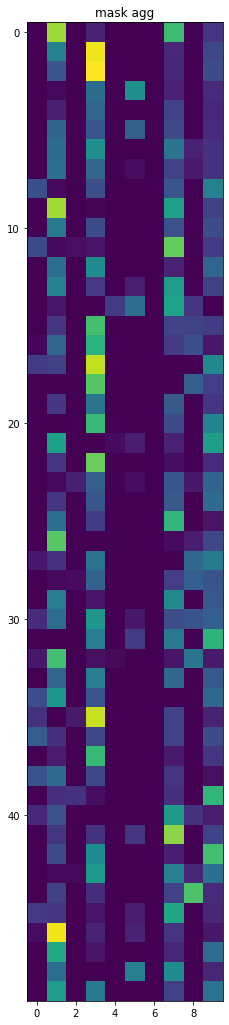

In [ ]:
fig, axs = plt.subplots(1, figsize=(18,18))

axs.imshow(explain_matrix[:50])
axs.set_title(f"mask agg")

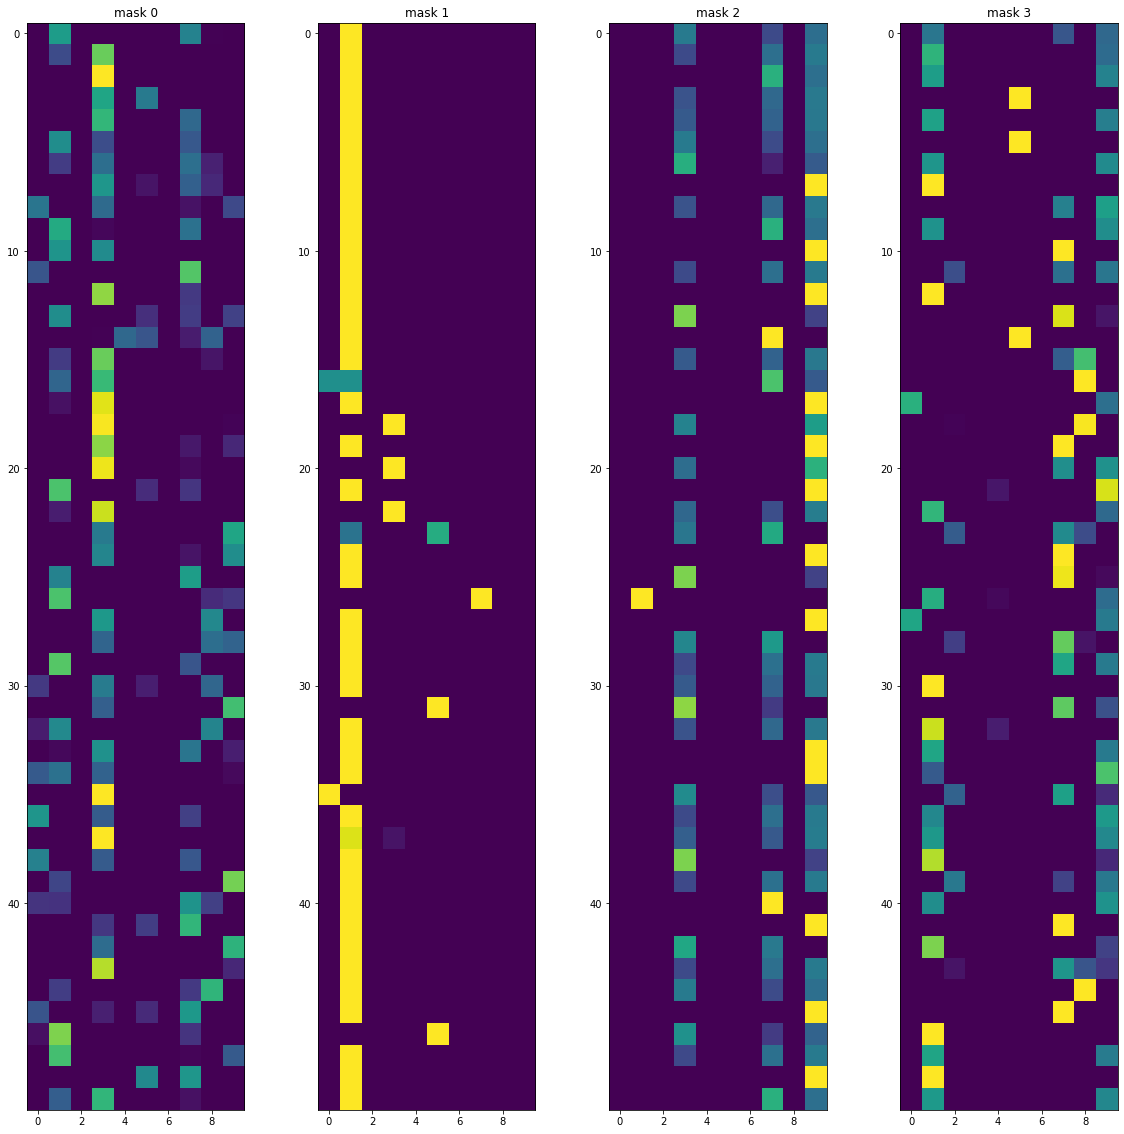

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20,20))

for i in range(4):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGBoost

In [ ]:
train = pd.read_csv(out, header = None, names = feature_columns)

In [ ]:
test = pd.read_csv(out_1, header = None, names = feature_columns)

In [ ]:
for col in feature_columns:
  if col != 'Poker Hand':
    train[col]= train[col].astype("category")
    test[col]= test[col].astype("category")



In [ ]:
train.dtypes

S1            category
C1            category
S2            category
C2            category
S3            category
C3            category
S4            category
C4            category
S5            category
C5            category
Poker Hand       int64
dtype: object

In [ ]:
test.dtypes

S1            category
C1            category
S2            category
C2            category
S3            category
C3            category
S4            category
C4            category
S5            category
C5            category
Poker Hand       int64
dtype: object

In [ ]:
!pip uninstall xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90


In [ ]:
!pip install xgboost==1.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 59 kB/s 


In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.model_selection import GridSearchCV
PARAMETERS = { 'learning_rate': [1e-3, 1e-2, 0.1, 0.3],'max_depth': [3, 5, 10],'n_estimators': [50, 100, 500, 1000],}

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train.drop(columns = ['Poker Hand']), train['Poker Hand'], test_size = 0.1)

In [ ]:
model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, scale_pos_weight=2400)
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="accuracy")
model_gs.fit(x_train,y_train,early_stopping_rounds=10,eval_set=eval_set,verbose=0)
print(model_gs.best_params_)

In [ ]:
eval_set = [(x_train, y_train), (x_val, y_val)]

In [ ]:
model = xgb.XGBClassifier(tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False,n_estimators=100, n_jobs=-1)
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="accuracy")
model_gs.fit(x_train,y_train,early_stopping_rounds=10,eval_set=eval_set,verbose=0)
print(model_gs.best_params_)

In [ ]:
clf = xgb.XGBClassifier(
    tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False, max_depth=5,learning_rate=0.3,n_estimators=500,max_cat_to_one_hot=20
)

In [ ]:
eval_set = [(x_train, y_train), (x_val, y_val)]

In [ ]:
clf.fit(x_train, y_train,eval_set=eval_set,verbose=1)

[10:49:51] WARNING: ../src/learner.cc:627: 
Parameters: { "max_cat_to_one_hot" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.76990	validation_1-mlogloss:1.78384
[1]	validation_0-mlogloss:1.51361	validation_1-mlogloss:1.53339
[2]	validation_0-mlogloss:1.35362	validation_1-mlogloss:1.38043
[3]	validation_0-mlogloss:1.23786	validation_1-mlogloss:1.27222
[4]	validation_0-mlogloss:1.15036	validation_1-mlogloss:1.19091
[5]	validation_0-mlogloss:1.08295	validation_1-mlogloss:1.12896
[6]	validation_0-mlogloss:1.03237	validation_1-mlogloss:1.08487
[7]	validation_0-mlogloss:0.98605	validation_1-mlogloss:1.04272
[8]	validation_0-mlogloss:0.95070	validation_1-mlogloss:1.01498
[9]	validation_0-mlogloss:0.91947	validation_1-mlogloss

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_one_hot=20,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

In [ ]:
predictions = clf.predict(x_val)
from sklearn.metrics import accuracy_score
print('Accuracy:',accuracy_score(y_val, predictions))

Accuracy: 0.9260295881647341


In [ ]:
predictions = clf.predict(test.drop(columns = ['Poker Hand']))
from sklearn.metrics import accuracy_score
print('Accuracy:',accuracy_score(test['Poker Hand'], predictions))

Accuracy: 0.929466


In [ ]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = features
feature_importances["importance"] = x.feature_importances_

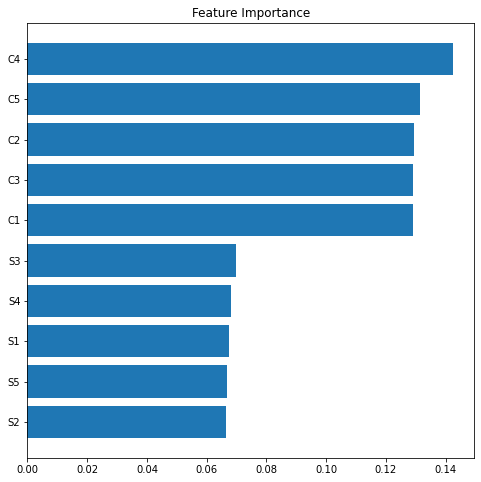

In [ ]:
feature_importances.sort_values(
    by = "importance", 
    ascending = True, 
    inplace = True
)
plt.figure(figsize = (8, 8))
plt.barh(feature_importances["feature"], feature_importances["importance"])
plt.title("Feature Importance")
plt.show()

#Test tham số TabNet

##N_d lớn

In [ ]:
clf = TabNetClassifier(
    n_d=512, n_a=16, n_steps=4,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=[3,12,3,12,3,12,3,12,3,12],
    gamma=1.5, n_ind=2, n_shared=2,
    lambda_sparse=1e-6, momentum=0.05, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 80},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'val'],
    max_epochs=800, patience=100,
    batch_size=4096, vbs=1024 #, augmentations=aug
) 

epoch 0  | loss: 5.04429 | train_accuracy: 0.44942 | val_accuracy: 0.44302 |  0:00:01s
epoch 1  | loss: 2.29237 | train_accuracy: 0.47212 | val_accuracy: 0.45062 |  0:00:02s
epoch 2  | loss: 1.88303 | train_accuracy: 0.4675  | val_accuracy: 0.46421 |  0:00:03s
epoch 3  | loss: 1.73831 | train_accuracy: 0.48025 | val_accuracy: 0.4882  |  0:00:03s
epoch 4  | loss: 1.57719 | train_accuracy: 0.46381 | val_accuracy: 0.44702 |  0:00:05s
epoch 5  | loss: 1.45227 | train_accuracy: 0.47114 | val_accuracy: 0.45942 |  0:00:05s
epoch 6  | loss: 1.41251 | train_accuracy: 0.47785 | val_accuracy: 0.45622 |  0:00:06s
epoch 7  | loss: 1.34491 | train_accuracy: 0.47763 | val_accuracy: 0.47341 |  0:00:07s
epoch 8  | loss: 1.28263 | train_accuracy: 0.48701 | val_accuracy: 0.47341 |  0:00:08s
epoch 9  | loss: 1.26255 | train_accuracy: 0.46133 | val_accuracy: 0.43782 |  0:00:09s
epoch 10 | loss: 1.24574 | train_accuracy: 0.47994 | val_accuracy: 0.46661 |  0:00:10s
epoch 11 | loss: 1.15139 | train_accuracy: 

/content/Thesis/Code/callbacks.py:155: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR poker-hand-train : 0.521548


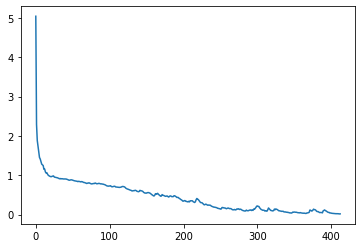

In [ ]:
plt.plot(clf.history['loss'])

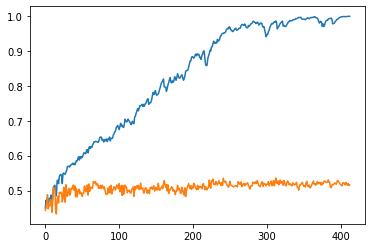

In [ ]:
# plot mse
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['val_accuracy'])

##N_d nhỏ

In [ ]:
clf = TabNetClassifier(
    n_d=2, n_a=16, n_steps=5,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=[3,12,3,12,3,12,3,12,3,12],
    gamma=1.5, n_ind=2, n_shared=2,
    lambda_sparse=1e-6, momentum=0.05, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 80},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'val'],
    max_epochs=3000, patience=1000,
    batch_size=4096, vbs=1024 #, augmentations=aug
) 

epoch 0  | loss: 2.81962 | train_accuracy: 0.00538 | val_accuracy: 0.0064  |  0:00:02s
epoch 1  | loss: 2.36511 | train_accuracy: 0.10694 | val_accuracy: 0.11236 |  0:00:06s
epoch 2  | loss: 2.19846 | train_accuracy: 0.22347 | val_accuracy: 0.22191 |  0:00:09s
epoch 3  | loss: 2.09406 | train_accuracy: 0.32138 | val_accuracy: 0.32107 |  0:00:12s
epoch 4  | loss: 1.99059 | train_accuracy: 0.38211 | val_accuracy: 0.37185 |  0:00:15s
epoch 5  | loss: 1.89216 | train_accuracy: 0.40344 | val_accuracy: 0.39464 |  0:00:18s
epoch 6  | loss: 1.79916 | train_accuracy: 0.41299 | val_accuracy: 0.40224 |  0:00:21s
epoch 7  | loss: 1.71847 | train_accuracy: 0.41721 | val_accuracy: 0.40944 |  0:00:24s
epoch 8  | loss: 1.63206 | train_accuracy: 0.41877 | val_accuracy: 0.41024 |  0:00:26s
epoch 9  | loss: 1.55038 | train_accuracy: 0.4221  | val_accuracy: 0.41263 |  0:00:29s
epoch 10 | loss: 1.46426 | train_accuracy: 0.42303 | val_accuracy: 0.41423 |  0:00:32s
epoch 11 | loss: 1.36901 | train_accuracy: 

/content/Thesis/Code/callbacks.py:155: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


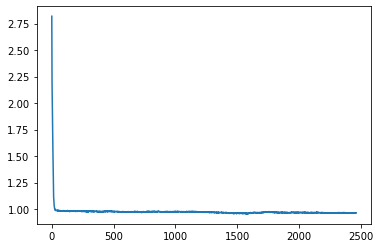

In [ ]:
plt.plot(clf.history['loss'])

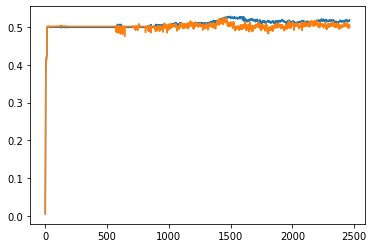

In [ ]:
# plot mse
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['val_accuracy'])

##N_a lớn

In [ ]:
clf = TabNetClassifier(
    n_d=16, n_a=512, n_steps=5,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=[3,12,3,12,3,12,3,12,3,12],
    gamma=1.5, n_ind=2, n_shared=2,
    lambda_sparse=1e-6, momentum=0.05, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 80},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'val'],
    max_epochs=3000, patience=3000,
    batch_size=4096, vbs=1024 #, augmentations=aug
) 

epoch 0  | loss: 2.38948 | train_accuracy: 0.48007 | val_accuracy: 0.46941 |  0:00:01s
epoch 1  | loss: 1.27062 | train_accuracy: 0.49211 | val_accuracy: 0.47221 |  0:00:02s
epoch 2  | loss: 1.13397 | train_accuracy: 0.48612 | val_accuracy: 0.4882  |  0:00:03s
epoch 3  | loss: 1.06056 | train_accuracy: 0.4942  | val_accuracy: 0.489   |  0:00:04s
epoch 4  | loss: 1.0196  | train_accuracy: 0.50255 | val_accuracy: 0.48181 |  0:00:06s
epoch 5  | loss: 1.00637 | train_accuracy: 0.50389 | val_accuracy: 0.4934  |  0:00:07s
epoch 6  | loss: 0.99254 | train_accuracy: 0.49709 | val_accuracy: 0.48541 |  0:00:08s
epoch 7  | loss: 0.9861  | train_accuracy: 0.50957 | val_accuracy: 0.48301 |  0:00:10s
epoch 8  | loss: 0.98161 | train_accuracy: 0.51157 | val_accuracy: 0.48101 |  0:00:11s
epoch 9  | loss: 0.98038 | train_accuracy: 0.51126 | val_accuracy: 0.4898  |  0:00:12s
epoch 10 | loss: 0.9776  | train_accuracy: 0.51215 | val_accuracy: 0.4938  |  0:00:13s
epoch 11 | loss: 0.97893 | train_accuracy: 

/content/Thesis/Code/callbacks.py:155: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


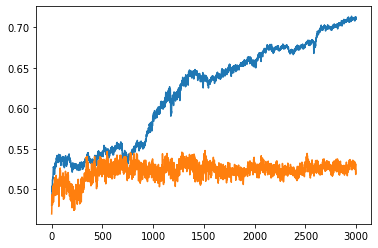

In [ ]:
# plot mse
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['val_accuracy'])

##N_a nhỏ

In [ ]:
clf = TabNetClassifier(
    n_d=8, n_a=2, n_steps=5,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=[3,12,3,12,3,12,3,12,3,12],
    gamma=1.5, n_ind=2, n_shared=2,
    lambda_sparse=1e-6, momentum=0.05, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 80},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/content/Thesis/Code/abstract_model.py:74: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_name = ['train', 'val'],
    max_epochs=3000, patience=3000,
    batch_size=4096, vbs=1024 #, augmentations=aug
) 

epoch 0  | loss: 3.60827 | train_accuracy: 0.11418 | val_accuracy: 0.10756 |  0:00:00s
epoch 1  | loss: 2.5191  | train_accuracy: 0.30135 | val_accuracy: 0.29588 |  0:00:01s
epoch 2  | loss: 1.91982 | train_accuracy: 0.41219 | val_accuracy: 0.41783 |  0:00:01s
epoch 3  | loss: 1.52854 | train_accuracy: 0.45018 | val_accuracy: 0.45062 |  0:00:02s
epoch 4  | loss: 1.31343 | train_accuracy: 0.47061 | val_accuracy: 0.48341 |  0:00:02s
epoch 5  | loss: 1.18224 | train_accuracy: 0.46288 | val_accuracy: 0.46022 |  0:00:03s
epoch 6  | loss: 1.12462 | train_accuracy: 0.47057 | val_accuracy: 0.45662 |  0:00:03s
epoch 7  | loss: 1.07573 | train_accuracy: 0.47501 | val_accuracy: 0.47221 |  0:00:04s
epoch 8  | loss: 1.05044 | train_accuracy: 0.4743  | val_accuracy: 0.46341 |  0:00:05s
epoch 9  | loss: 1.0332  | train_accuracy: 0.47559 | val_accuracy: 0.5018  |  0:00:05s
epoch 10 | loss: 1.02076 | train_accuracy: 0.48216 | val_accuracy: 0.48181 |  0:00:06s
epoch 11 | loss: 1.01889 | train_accuracy: 

/content/Thesis/Code/callbacks.py:155: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


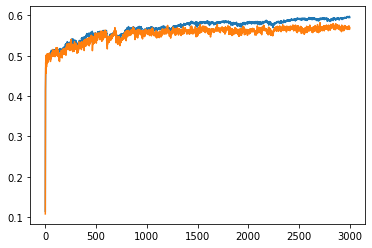

In [ ]:
# plot mse
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['val_accuracy'])